In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

In [40]:
path = 'data/healthcare-dataset-stroke-data.csv'

dataframe = pd.read_csv(path)
dataframe.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Some features contain missing values that need to be imputed or otherwise handled. Additionally, certain numerical features exhibit high cardinality, which may be better represented using binning or range-based grouping. Let's perform an exploratory analysis to determine the most suitable preprocessing strategies.

### Missing values and binning

In [41]:
def is_not_float_or_nan(x):
    return pd.isna(x) or not isinstance(x,float)

In [42]:
#get the values that are not float type
bmi = dataframe[['bmi']]
mask = bmi.applymap(is_not_float_or_nan)
nan_count = mask.sum().item()

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_16681/1820511369.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = bmi.applymap(is_not_float_or_nan)


In [43]:
total = len(dataframe)
not_nan_count = total - nan_count

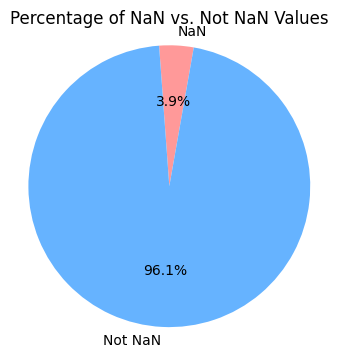

In [44]:
# Labels and percentages
labels = ['NaN', 'Not NaN']
sizes = [nan_count, not_nan_count]
colors = ['#ff9999','#66b3ff']

# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=80)
plt.title('Percentage of NaN vs. Not NaN Values')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()

As we see it's only 3.9% of the data that have missing values. So I use the techniques to fill that missing values and then apply bining to the some features of the data set, like age,bmi and average glucose level.

I binned the age feature into defined ranges and added a new column to display the age group for each entry in the dataset.

In [45]:
bins = [0, 2, 18, 40, 60, 82]
labels = ['newborn', 'child', 'young adult', 'middle age', 'senior']

dataframe['age_group'] = pd.cut(dataframe['age'],bins = bins,labels = labels,right=True)


In [46]:
dataframe

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,senior
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,senior
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,senior
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,middle age
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,senior
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,senior
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,young adult
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,middle age


By binning the age feature into defined groups, we can impute missing BMI values more effectively. The approach involves replacing a missing BMI with the average BMI of the corresponding age group. This method is likely to be more accurate than simply using the overall average BMI across the entire dataset.

For each group range calculate the bmi average value.

In [47]:
bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()


/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_16681/4007097876.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()


In [48]:
dataframe[dataframe['age_group']== 'newborn']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1,newborn
363,7559,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0,newborn
376,22706,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0,newborn
437,5010,Female,2.00,0,0,No,children,Rural,92.48,18.0,Unknown,0,newborn
562,45238,Female,1.80,0,0,No,children,Urban,58.26,16.5,Unknown,0,newborn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961,3720,Female,2.00,0,0,No,children,Rural,80.30,21.2,Unknown,0,newborn
5032,67426,Female,1.24,0,0,No,children,Rural,61.94,20.3,Unknown,0,newborn
5079,42709,Male,1.72,0,0,No,children,Urban,77.28,17.1,Unknown,0,newborn
5089,56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0,newborn


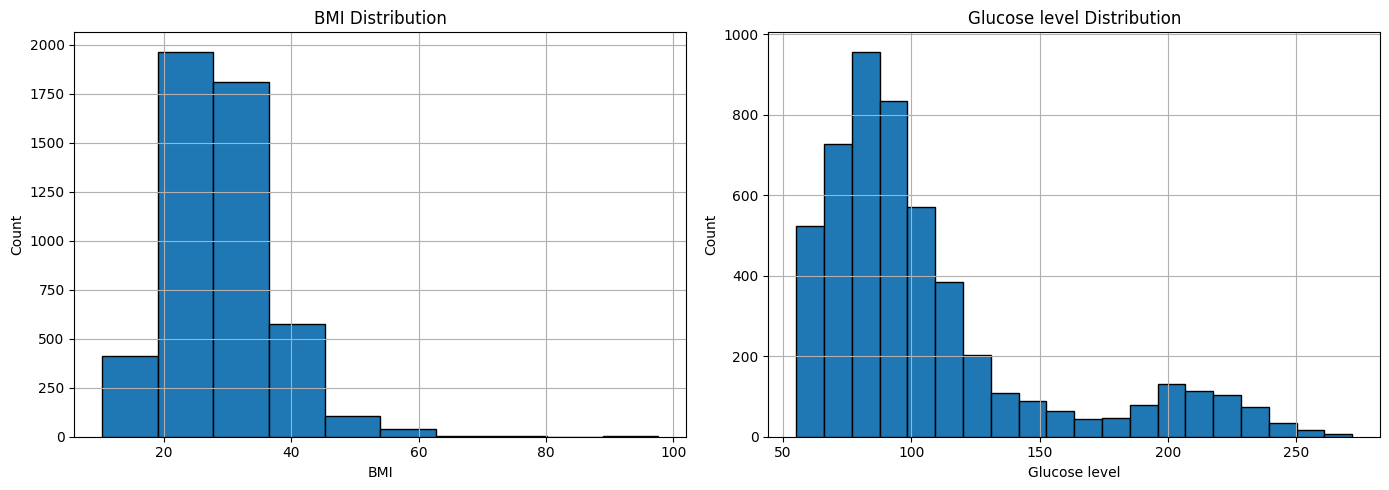

In [49]:
#plot the bmi that was before 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(dataframe['bmi'], bins=10, edgecolor='black')
axes[0].set_title('BMI Distribution')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].hist(dataframe['avg_glucose_level'], bins=20, edgecolor='black')
axes[1].set_title('Glucose level Distribution')
axes[1].set_xlabel('Glucose level')
axes[1].set_ylabel('Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [14]:
bmi_mean_by_age

{'newborn': 18.676923076923078,
 'child': 22.421349862258953,
 'young adult': 29.705740884406513,
 'middle age': 31.6684350132626,
 'senior': 29.873377156943306}

In [50]:
#filling the missing values
for key,val in bmi_mean_by_age.items():
    mask = (dataframe['age_group'] == key) & (dataframe['bmi'].isna())
    dataframe.loc[mask,'bmi'] = val
    
dataframe['bmi'] = dataframe['bmi'].round(2)

#discretization and smoothing for bmi
# Define bin edges from 10 to 100 with a step of 10
bin_edges_bmi = np.arange(10, 100 + 5, 5)  # [10, 20, 30, ..., 100]

# Create BMI bins
dataframe['bmi_bin'] = pd.cut(dataframe['bmi'], bins=bin_edges_bmi, include_lowest=True)

# Replace BMI values with bin means
dataframe['bmi'] = dataframe.groupby('bmi_bin')['bmi'].transform('mean')





/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_16681/3366143726.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataframe['bmi'] = dataframe.groupby('bmi_bin')['bmi'].transform('mean')


In [53]:
bin_edges_glucose = np.arange(55, 275 +20, 20)  # [55, 75, 95, ..., 275]

# Create bins
dataframe['glucose_bin'] = pd.cut(dataframe['avg_glucose_level'], bins=bin_edges_glucose, include_lowest=True)

# Replace values with mean of their bin
dataframe['avg_glucose_level'] = dataframe.groupby('glucose_bin')['avg_glucose_level'].transform('mean')

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_16681/1372072189.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataframe['avg_glucose_level'] = dataframe.groupby('glucose_bin')['avg_glucose_level'].transform('mean')


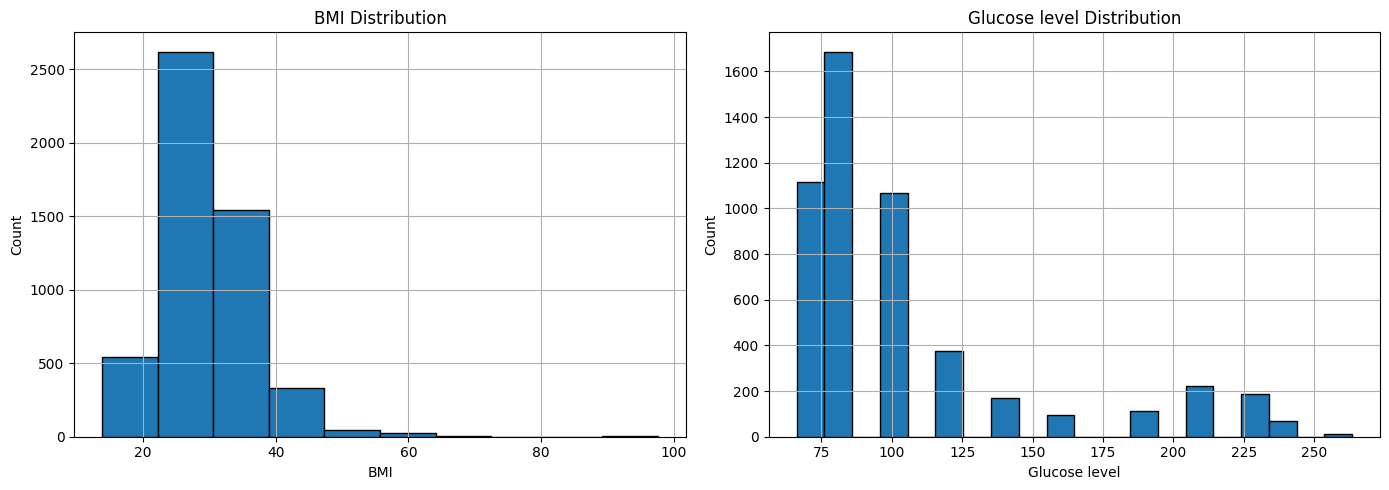

In [17]:
#plot the bmi that was before 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(dataframe['bmi'], bins=10, edgecolor='black')
axes[0].set_title('BMI Distribution')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].hist(dataframe['avg_glucose_level'], bins=20, edgecolor='black')
axes[1].set_title('Glucose level Distribution')
axes[1].set_xlabel('Glucose level')
axes[1].set_ylabel('Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Binarization 

In [ ]:
# Converting 'smoking_status' to binary: smoker = 1, else = 0
#dataframe['smokes'] = (dataframe['smoking_status'] == 'smokes').astype(int)
#dataframe['never smoked'] = (dataframe['smoking_status'] == 'never smoked').astype(int)
#dataframe['formerly smoked'] = (dataframe['smoking_status'] == 'formerly smoked').astype(int)

In [54]:
dataframe = dataframe.drop(['id','age','bmi_bin','glucose_bin'],axis=1)
dataframe

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,0,1,Yes,Private,Urban,224.115957,37.245200,formerly smoked,1,senior
1,Female,0,0,Yes,Self-employed,Rural,204.627104,27.747544,never smoked,1,senior
2,Male,0,1,Yes,Private,Rural,104.055009,32.295168,never smoked,1,senior
3,Female,0,0,Yes,Private,Urban,164.078105,32.295168,smokes,1,middle age
4,Female,1,0,Yes,Self-employed,Rural,164.078105,22.759631,never smoked,1,senior
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,1,0,Yes,Private,Urban,84.869158,27.747544,never smoked,0,senior
5106,Female,0,0,Yes,Self-employed,Urban,123.286037,37.245200,never smoked,0,senior
5107,Female,0,0,Yes,Self-employed,Rural,84.869158,32.295168,never smoked,0,young adult
5108,Male,0,0,Yes,Private,Rural,164.078105,27.747544,formerly smoked,0,middle age


### SMOTE

In [55]:
from scipy.stats import norm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [57]:
#Encode categorical values
from sklearn.preprocessing import OrdinalEncoder
categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['gender',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'age_group']

In [58]:
encoder =OrdinalEncoder()

dataframe_cp = dataframe.copy()
dataframe_cp[categorical_columns] = encoder.fit_transform(dataframe[categorical_columns])

In [59]:
dataframe_cp

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,1.0,0,1,1.0,2.0,1.0,224.115957,37.245200,1.0,1,3.0
1,0.0,0,0,1.0,3.0,0.0,204.627104,27.747544,2.0,1,3.0
2,1.0,0,1,1.0,2.0,0.0,104.055009,32.295168,2.0,1,3.0
3,0.0,0,0,1.0,2.0,1.0,164.078105,32.295168,3.0,1,1.0
4,0.0,1,0,1.0,3.0,0.0,164.078105,22.759631,2.0,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,1,0,1.0,2.0,1.0,84.869158,27.747544,2.0,0,3.0
5106,0.0,0,0,1.0,3.0,1.0,123.286037,37.245200,2.0,0,3.0
5107,0.0,0,0,1.0,3.0,0.0,84.869158,32.295168,2.0,0,4.0
5108,1.0,0,0,1.0,2.0,0.0,164.078105,27.747544,1.0,0,1.0


In [60]:
# Separate features and labels
X = dataframe_cp.drop('stroke', axis=1)
y = dataframe_cp['stroke']

# Split before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
smote = SMOTE(random_state=42)
X_res_train, y_res_train = smote.fit_resample(X_train, y_train)

In [21]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(X_res_train, y_res_train)

In [22]:
y_pred = clf.predict(X_test)

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       960
           1       0.18      0.15      0.16        62

    accuracy                           0.91      1022
   macro avg       0.56      0.55      0.56      1022
weighted avg       0.90      0.91      0.90      1022



In [24]:
y_probs = clf.predict_proba(X_test)[:,1]

In [26]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC score:", auc)

AUC score: 0.5620967741935484


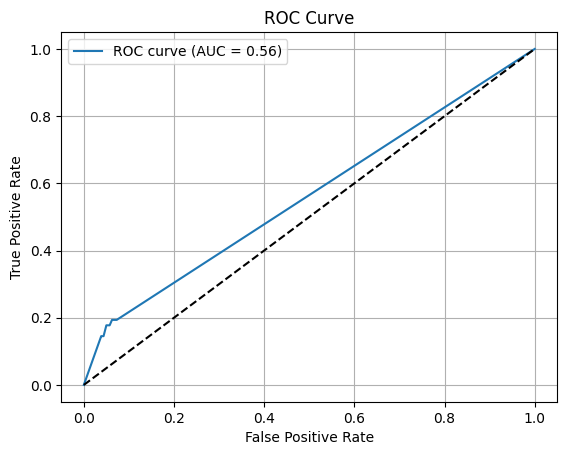

In [27]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal (random)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

Also we need to preproccess the data that have values like Yes/No for the ever married feature, make it binary 0/1

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       960
           1       0.14      0.11      0.12        62

    accuracy                           0.90      1022
   macro avg       0.54      0.53      0.54      1022
weighted avg       0.89      0.90      0.90      1022



In [62]:
from sklearn.ensemble import RandomForestClassifier

# Create the model
rf = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')

# Train the model
rf.fit(X_res_train, y_res_train)

# Predict
y_pred_for = rf.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred_for))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.11      0.02      0.03        62

    accuracy                           0.93      1022
   macro avg       0.53      0.50      0.50      1022
weighted avg       0.89      0.93      0.91      1022



In [35]:
y_probs_fr = rf.predict_proba(X_test)[:,1]
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_fr)

# Compute AUC
auc = roc_auc_score(y_test, y_probs_fr)
print("AUC score:", auc)


AUC score: 0.7195060483870968


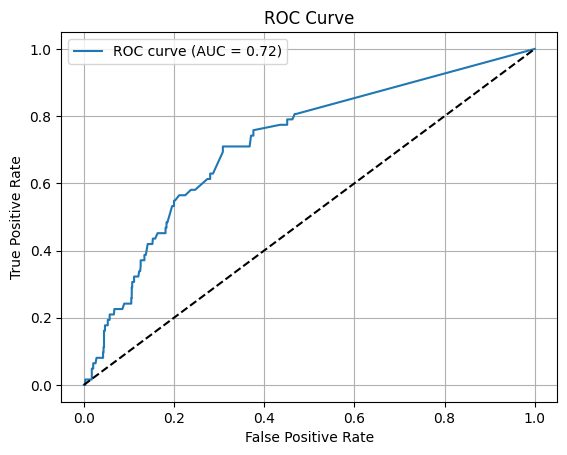

In [31]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal (random)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix

In [38]:
cm = confusion_matrix(y_test, y_pred_for)

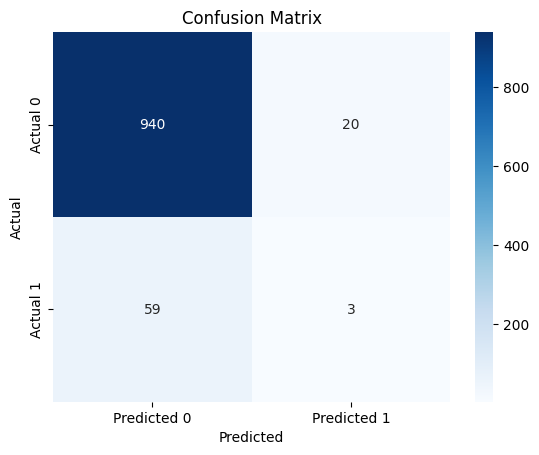

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
from collections import Counter

counter = Counter(y_res_train)

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_res_train, y_res_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [23]:
y_pred = model.predict(X_test)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       960
           1       0.10      0.34      0.16        62

    accuracy                           0.78      1022
   macro avg       0.53      0.57      0.51      1022
weighted avg       0.90      0.78      0.83      1022



In [ ]:
# Encode 'Sex' column
dataframe.loc[:, 'ever_married'] = dataframe['ever_married'].map({'No': 0, 'Yes': 1})

Let's analyze the connections between , age and stroke, average glucose level and stroke, bmi amd age 

In [76]:
# Group by age and stroke, then calculate the mean glucose
grouped = dataframe.groupby(['age', 'stroke'])['avg_glucose_level'].mean().unstack()

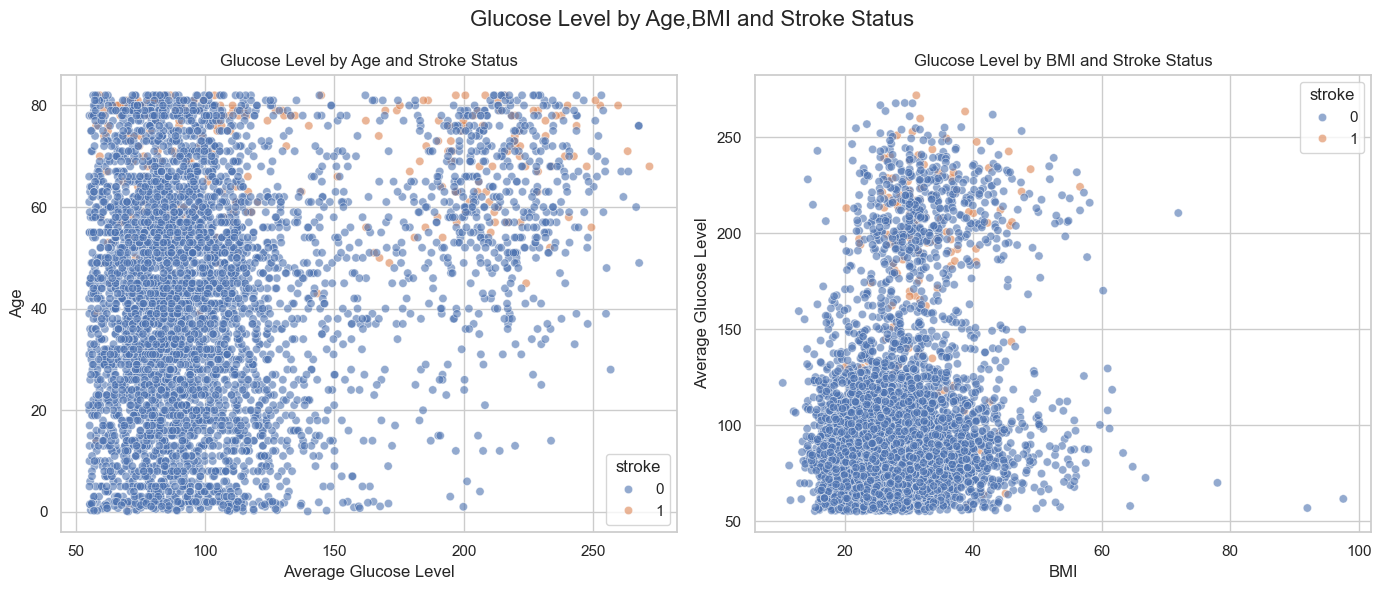

In [92]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data= dataframe, x='avg_glucose_level', y='age', hue='stroke', alpha=0.6,  ax=axes[0])

axes[0].set_title("Glucose Level by Age and Stroke Status")
axes[0].set_xlabel("Average Glucose Level")
axes[0].set_ylabel("Age")

sns.scatterplot(data= dataframe, y='avg_glucose_level', x='bmi', hue='stroke', alpha=0.6,  ax=axes[1])
axes[1].set_title("Glucose Level by BMI and Stroke Status")
axes[1].set_ylabel("Average Glucose Level")
axes[1].set_xlabel("BMI")

# Overall figure title
plt.suptitle('Glucose Level by Age,BMI and Stroke Status', fontsize=16)
plt.tight_layout()
plt.show()

Distribution of numerical attributes with stroke and each other.This plot present the distribution plots for age agains average glucose level, bmi against average glucose level based on stroke occurance.
We can observe a relationship between average glucose level and stroke risk at certain age ranges. Specifically, higher glucose levels in older individuals appear to be associated with a greater likelihood of stroke. In contrast, there is no clear correlation between average glucose level and BMI — the glucose levels vary widely across similar BMI values. Therefore, we can conclude that the connection between glucose levels and age in relation to stroke is stronger than the relationship between BMI, glucose, and stroke.

### Lets see how the hypertension and heart desiases effects possibility of stroke.

In [97]:
hypertension_stroke = dataframe[(dataframe['hypertension'] == 1) & (dataframe['stroke'] == 1)].shape[0]
no_hypertension_stroke = dataframe[(dataframe['hypertension']==0) & (dataframe['stroke'] == 1)].shape[0]
hypertension_no_stroke = dataframe[(dataframe['hypertension'] == 1) & (dataframe['stroke'] == 0)].shape[0]

In [98]:
hypertension_stroke,no_hypertension_stroke,hypertension_no_stroke

(66, 183, 432)

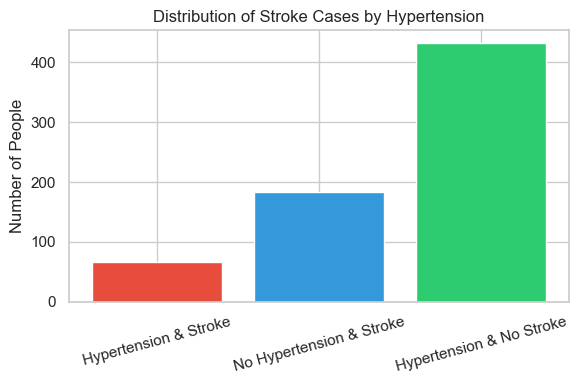

In [103]:
labels = ['Hypertension & Stroke', 'No Hypertension & Stroke', 'Hypertension & No Stroke']
counts = [
    hypertension_stroke,
    no_hypertension_stroke,
    hypertension_no_stroke
]


plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['#e74c3c', '#3498db', '#2ecc71'])
plt.title('Distribution of Stroke Cases by Hypertension')
plt.ylabel('Number of People')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

We can see that the number of cases where hypertension exists but no stroke occurred is significantly higher. However, it's important to note that the overall number of stroke cases is relatively low in the dataset, so direct comparison between stroke and non-stroke groups may be misleading.

Let's analyze how the smoking effects stroke 

In [ ]:
unique_val = dataframe['smoking_status'].unique()

In [107]:
unique_val

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [114]:
num_unknown = dataframe[dataframe['smoking_status']=='Unknown'].shape[0]
num_unknown

1544

### Hypertension in ages 60-100
 

In [132]:
mask = (dataframe['hypertension'] == 1) & (dataframe['age_group'].isin(['61-80', '81-100']))
num_of_hypertension_by_age = mask.sum()
print(num_of_hypertension_by_age)

282


In [133]:
mask = (dataframe['hypertension'] == 0) & (dataframe['age_group'].isin(['61-80', '81-100']))
num_of_non_hypertension_by_age = mask.sum()
print(num_of_non_hypertension_by_age)

1022


We have 1544 unknown status for smoking so we won't use this rows with Unknown values for analyzing the conncetion between smoking and stroke.

### Preproccess the string values in the data set

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataframe['work_type_encoded'] = le.fit_transform(dataframe['work_type'])


Discovering the numbers of strokes verses non stroke cases in the data set.

In [37]:
stroke_num = dataframe[['stroke']].sum().item()
non_stroke = len(dataframe) - stroke_num

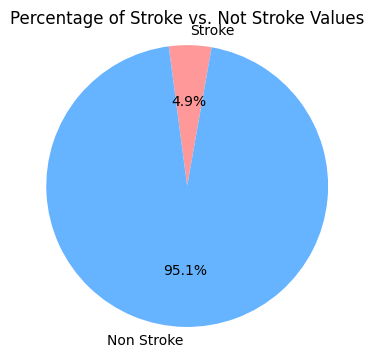

In [39]:
# Labels and percentages
labels = ['Stroke', 'Non Stroke']
sizes = [stroke_num, non_stroke]
colors = ['#ff9999','#66b3ff']

# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=80)
plt.title('Percentage of Stroke vs. Not Stroke Values')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()

We have a relatively small number of stroke cases—approximately 5% of the entire dataset. This creates a class imbalance problem, which can negatively affect the model’s ability to accurately classify stroke cases versus non-stroke cases. Due to the imbalance, the model is more likely to learn patterns from the majority class (non-stroke), leading to poor detection of stroke instances. To address this issue, I will apply specific techniques to mitigate the effects of the imbalance.

SMOTE is used to increase the representation of the minority class labels by generating synthetic samples.


Here’s how SMOTE works (simplified).

1. Randomly select some data points in the minority class.
2. For every selected point, identify its k nearest neighbour(s).
3. For every neighbor, add a new point somewhere between the data point and the neighbor.
4. Repeat steps 2 to 4 until sufficient synthetic data points are created.